# 1. Dependencies

In [ ]:
!pip install opencv-python matplotlib imageio gdown tensorflow


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import os
import cv2
import tensorflow as tf
import numpy as np
from typing import List
from matplotlib import pyplot as plt
import imageio
import gdown

In [ ]:
#prevent exponentially memory growth
physical_devices = tf.config.list_physical_devices("GPU")
try:
  tf.config.experimental.set_memory_growth(physical_devices[0], True)
except:
  pass

In [ ]:
tf.config.list_physical_devices("GPU")

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

# 2. Data Loading

In [ ]:
url = 'https://drive.google.com/uc?id=1YlvpDLix3S-U8fd-gqRwPcWXAXm8JwjL'
output = "data.zip"
gdown.download(url, output, quiet=False)
gdown.extractall("data.zip")

Downloading...
From: https://drive.google.com/uc?id=1YlvpDLix3S-U8fd-gqRwPcWXAXm8JwjL
To: /content/data.zip
100%|██████████| 423M/423M [00:04<00:00, 86.3MB/s]


['data/',
 'data/alignments/',
 'data/alignments/s1/',
 'data/alignments/s1/bbaf2n.align',
 'data/alignments/s1/bbaf3s.align',
 'data/alignments/s1/bbaf4p.align',
 'data/alignments/s1/bbaf5a.align',
 'data/alignments/s1/bbal6n.align',
 'data/alignments/s1/bbal7s.align',
 'data/alignments/s1/bbal8p.align',
 'data/alignments/s1/bbal9a.align',
 'data/alignments/s1/bbas1s.align',
 'data/alignments/s1/bbas2p.align',
 'data/alignments/s1/bbas3a.align',
 'data/alignments/s1/bbaszn.align',
 'data/alignments/s1/bbaz4n.align',
 'data/alignments/s1/bbaz5s.align',
 'data/alignments/s1/bbaz6p.align',
 'data/alignments/s1/bbaz7a.align',
 'data/alignments/s1/bbbf6n.align',
 'data/alignments/s1/bbbf7s.align',
 'data/alignments/s1/bbbf8p.align',
 'data/alignments/s1/bbbf9a.align',
 'data/alignments/s1/bbbm1s.align',
 'data/alignments/s1/bbbm2p.align',
 'data/alignments/s1/bbbm3a.align',
 'data/alignments/s1/bbbmzn.align',
 'data/alignments/s1/bbbs4n.align',
 'data/alignments/s1/bbbs5s.align',
 'data/al

In [ ]:
def load_video(path:str) -> List[float]: 

    cap = cv2.VideoCapture(path)
    frames = []
    for _ in range(int(cap.get(cv2.CAP_PROP_FRAME_COUNT))): 
        ret, frame = cap.read()
        frame = tf.image.rgb_to_grayscale(frame)
        frames.append(frame[190:236,80:220,:])
    cap.release()
    
    mean = tf.math.reduce_mean(frames)
    std = tf.math.reduce_std(tf.cast(frames, tf.float32))
    return tf.cast((frames - mean), tf.float32) / std



In [ ]:
vocab = [x for x in "abcdefghijklmnopqrstuvwxyz'?!123456789 "]

In [ ]:
char_to_num = tf.keras.layers.StringLookup(vocabulary=vocab, oov_token="")
num_to_char = tf.keras.layers.StringLookup(
    vocabulary=char_to_num.get_vocabulary(), oov_token="", invert=True
)

print(
    f"The vocabulary is: {char_to_num.get_vocabulary()} "
    f"(size ={char_to_num.vocabulary_size()})")

The vocabulary is: ['', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', "'", '?', '!', '1', '2', '3', '4', '5', '6', '7', '8', '9', ' '] (size =40)


In [ ]:
def load_alignments(path:str) -> List[str]: 
    with open(path, 'r') as f: 
        lines = f.readlines() 
    tokens = []
    for line in lines:
        line = line.split()
        if line[2] != 'sil': 
            tokens = [*tokens,' ',line[2]]
    return char_to_num(tf.reshape(tf.strings.unicode_split(tokens, input_encoding='UTF-8'), (-1)))[1:]

In [ ]:

def load_data(path: str):
    #print(path)
    path = tf.convert_to_tensor(path)
    #print(path) 
    path = path.numpy().decode("utf-8")
   #print(path)
    #path = tf.convert_to_tensor(path).numpy().decode("utf-8")
    #file_name = path.split('/')[-1].split('.')[0]
    # File name splitting for windows
    file_name = path.split('/')[-1].split('.')[0]
    #print(file_name)
    video_path = os.path.join('data','s1',f'{file_name}.mpg')
    #print(video_path)
    alignment_path = os.path.join('data','alignments','s1',f'{file_name}.align')
    #print(alignment_path)
    frames = load_video(video_path)
    #print(frames) 
    alignments = load_alignments(alignment_path)
    
    return frames, alignments

In [ ]:
test_path = "/content/data/s1/bbal8p.mpg"


In [ ]:
tf.convert_to_tensor(test_path).numpy().decode("utf-8").split("/")[-1].split('.')[0]


'bbal8p'

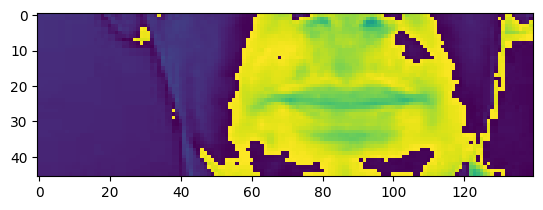

In [ ]:

frames, alignment = load_data(test_path) 
# we get a tensor  with a shape: 75 (frames in length), 46, 140 (size in pixels), 1 (one chanel )
plt.imshow(frames[63])

In [ ]:
alignment

<tf.Tensor: shape=(26,), dtype=int64, numpy=
array([ 2,  9, 14, 39,  2, 12, 21,  5, 39,  1, 20, 39, 12, 39,  5,  9,  7,
        8, 20, 39, 16, 12,  5,  1, 19,  5])>

In [ ]:
tf.strings.reduce_join([bytes.decode(x) for x in num_to_char(alignment.numpy()).numpy()])

<tf.Tensor: shape=(), dtype=string, numpy=b'bin blue at l eight please'>

In [ ]:
def mappable_function(path:str) ->List[str]:
  result = tf.py_function(load_data, [path], (tf.float32, tf.int64))
  return result

# 3. Create Data Pipeline

In [ ]:
#1
data = tf.data.Dataset.list_files('./data/s1/*.mpg')

In [ ]:
data.as_numpy_iterator().next()

b'./data/s1/sgio9a.mpg'

In [ ]:
#2
data = data.shuffle(500)


In [ ]:
#3
data = data.map(mappable_function)

array([ 2,  9, 14, 39,  2, 12, 21,  5, 39,  2, 25, 39, 13, 39, 20, 23, 15,
       39, 16, 12,  5,  1, 19,  5])

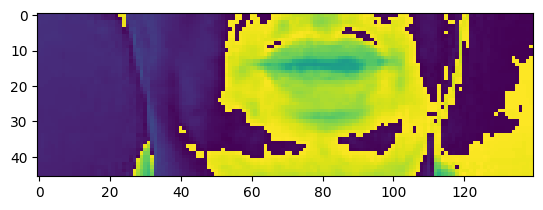

In [ ]:
frames, alignment = data.as_numpy_iterator().next()
plt.imshow(frames[33])
alignment

In [ ]:

#4  - padd the alignment size 
data = data.padded_batch(2, padded_shapes=([75, None, None, None],[40]))
# 2: is 2 groups of videos and alignments, 40: si the size for the alignments , smaller than that will be padded to 40

In [ ]:
#5 - loading data while our model is training
data = data.prefetch(tf.data.AUTOTUNE)

In [ ]:
frames, alignment = data.as_numpy_iterator().next()

In [ ]:
len(frames) # we will get 2 , each batch has 2 videos

2

In [ ]:
# Added for split 
train = data.take(450)
test = data.skip(450)

## Create and test a sample dataset

In [ ]:
  # Create sample dataset
test = data.as_numpy_iterator()

In [ ]:
val = test.next(); val[0] # val[0] returns the frames

array([[[[[1.2209439 ],
          [1.3354074 ],
          [0.8393989 ],
          ...,
          [0.30523598],
          [0.30523598],
          [0.30523598]],

         [[1.1064804 ],
          [1.2972529 ],
          [0.76308995],
          ...,
          [0.30523598],
          [0.30523598],
          [0.30523598]],

         [[1.5261799 ],
          [1.5261799 ],
          [1.2972529 ],
          ...,
          [0.34339046],
          [0.30523598],
          [0.30523598]],

         ...,

         [[1.144635  ],
          [1.0683259 ],
          [1.0683259 ],
          ...,
          [0.0381545 ],
          [0.0381545 ],
          [0.0381545 ]],

         [[1.0683259 ],
          [1.0683259 ],
          [1.0683259 ],
          ...,
          [0.0381545 ],
          [0.0381545 ],
          [0.0381545 ]],

         [[1.0683259 ],
          [1.0683259 ],
          [1.0683259 ],
          ...,
          [0.0381545 ],
          [0.0381545 ],
          [0.        ]]],


        [[[1.3354

In [ ]:
# create a gif with our frames in the files folder
imageio.mimsave('./animation.gif', val[0][1], fps=15)
 # 0 is for selecting frames 1 is for selecting second video from the batch

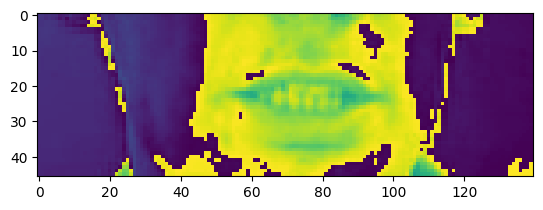

In [ ]:
plt.imshow(val[0][1][22])
# 0: select videos, 1: second video from the batch, 22 : the frame 

In [ ]:
tf.strings.reduce_join([num_to_char(word) for word in val[1][0]])
#val[1]: returns alignment , [0]: first video

<tf.Tensor: shape=(), dtype=string, numpy=b'place white with e three again'>

# 4. Design the Deep Neural Network

In [ ]:
from tensorflow.keras.models import Sequential 
from tensorflow.keras.layers import Conv3D, LSTM, Dense, Dropout, Bidirectional, MaxPool3D, Activation, Reshape, SpatialDropout3D, BatchNormalization, TimeDistributed, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler

In [ ]:
data.as_numpy_iterator().next()[0][0].shape


(75, 46, 140, 1)

In [ ]:
model = Sequential()
model.add(Conv3D(128, 3, input_shape=(75,46,140,1), padding='same'))
model.add(Activation('relu'))
model.add(MaxPool3D((1,2,2)))

model.add(Conv3D(256, 3, padding='same'))
model.add(Activation('relu'))
model.add(MaxPool3D((1,2,2)))

model.add(Conv3D(75, 3, padding='same'))
model.add(Activation('relu'))
model.add(MaxPool3D((1,2,2)))

model.add(TimeDistributed(Flatten()))

model.add(Bidirectional(LSTM(128, kernel_initializer='Orthogonal', return_sequences=True)))
model.add(Dropout(.5))

model.add(Bidirectional(LSTM(128, kernel_initializer='Orthogonal', return_sequences=True)))
model.add(Dropout(.5))

model.add(Dense(char_to_num.vocabulary_size()+1, kernel_initializer='he_normal', activation='softmax'))
#output shoud be 75(frames), 41(one-hot encoded representation of our characters)

In [ ]:
  model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_7 (Conv3D)           (None, 75, 46, 140, 128)  3584      
                                                                 
 activation_7 (Activation)   (None, 75, 46, 140, 128)  0         
                                                                 
 max_pooling3d_6 (MaxPooling  (None, 75, 23, 70, 128)  0         
 3D)                                                             
                                                                 
 conv3d_8 (Conv3D)           (None, 75, 23, 70, 256)   884992    
                                                                 
 activation_8 (Activation)   (None, 75, 23, 70, 256)   0         
                                                                 
 max_pooling3d_7 (MaxPooling  (None, 75, 11, 35, 256)  0         
 3D)                                                  

In [ ]:
#test our model to make a prediction
yhat = model.predict(val[0])

1/1 [==============================] - 3s 3s/step


In [ ]:
tf.strings.reduce_join([num_to_char(tf.argmax(x)) for x in yhat[1]])
#result is nonsense

<tf.Tensor: shape=(), dtype=string, numpy=b'6xxxxxxxxxxxxxxx6666666666666666666666xxxxxxxx66xxxxxxxxxx66666666666666622'>

In [ ]:
model.input_shape


(None, 75, 46, 140, 1)

In [ ]:
model.output_shape

(None, 75, 41)

# 5. Training Setup and Train

In [ ]:
# define learning scheduler
def scheduler(epoch, lr):
    if epoch < 30:
        return lr
    else:
        return lr * tf.math.exp(-0.1)

In [ ]:
# define custom loss function

def CTCLoss(y_true, y_pred):
    batch_len = tf.cast(tf.shape(y_true)[0], dtype="int64")
    input_length = tf.cast(tf.shape(y_pred)[1], dtype="int64")
    label_length = tf.cast(tf.shape(y_true)[1], dtype="int64")

    input_length = input_length * tf.ones(shape=(batch_len, 1), dtype="int64")
    label_length = label_length * tf.ones(shape=(batch_len, 1), dtype="int64")

    loss = tf.keras.backend.ctc_batch_cost(y_true, y_pred, input_length, label_length)
    return loss

# from https://keras.io/examples/audio/ctc_asr/#model

In [ ]:
class ProduceExample(tf.keras.callbacks.Callback): 
    def __init__(self, dataset) -> None: 
        self.dataset = dataset.as_numpy_iterator()
    
    def on_epoch_end(self, epoch, logs=None) -> None:
        data = self.dataset.next()
        yhat = self.model.predict(data[0])
        decoded = tf.keras.backend.ctc_decode(yhat, [75,75], greedy=False)[0][0].numpy()
        for x in range(len(yhat)):           
            print('Original:', tf.strings.reduce_join(num_to_char(data[1][x])).numpy().decode('utf-8'))
            print('Prediction:', tf.strings.reduce_join(num_to_char(decoded[x])).numpy().decode('utf-8'))
            print('~'*100)

In [ ]:
model.compile(optimizer=Adam(learning_rate=0.0001), loss=CTCLoss)

In [ ]:
checkpoint_callback = ModelCheckpoint(os.path.join('models','checkpoint'), monitor='loss', save_weights_only=True)

In [ ]:
schedule_callback = LearningRateScheduler(scheduler)

In [ ]:
# Added for split 
train = data.take(450)
test = data.skip(450)

In [ ]:
example_callback = ProduceExample(test)

In [ ]:
model.fit(train, validation_data=test, epochs=100, callbacks=[checkpoint_callback, schedule_callback, example_callback])

Epoch 1/100
1/1 [==============================] - 3s 3s/step
Original: place blue by c seven again
Prediction: la e e e o o
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: lay green with t three again
Prediction: la e e e o o
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
450/450 [==============================] - 869s 2s/step - loss: 83.7664 - val_loss: 69.3059 - lr: 1.0000e-04
Epoch 2/100
1/1 [==============================] - 0s 202ms/step
Original: lay red by y eight now
Prediction: la e e t e o
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: bin red with g seven soon
Prediction: la e e e on
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
450/450 [==============================] - 653s 1s/step - loss: 69.9538 - val_loss: 64.5113 - lr: 1.0000e-04
Epoch 

KeyboardInterrupt: ignored

# 6.Make Predictions

In [ ]:
url = 'https://drive.google.com/uc?id=1vWscXs4Vt0a_1IH1-ct2TCgXAZT-N3_Y'
output = 'checkpoints.zip'
gdown.download(url, output, quiet=False)
gdown.extractall('checkpoints.zip', 'models')

Downloading...
From: https://drive.google.com/uc?id=1vWscXs4Vt0a_1IH1-ct2TCgXAZT-N3_Y
To: /content/checkpoints.zip
100%|██████████| 94.5M/94.5M [00:02<00:00, 44.2MB/s]


['models/checkpoint.index',
 'models/__MACOSX/._checkpoint.index',
 'models/checkpoint.data-00000-of-00001',
 'models/__MACOSX/._checkpoint.data-00000-of-00001',
 'models/checkpoint',
 'models/__MACOSX/._checkpoint']

In [ ]:
# the checkpoint that was created using an older version of Keras
optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=0.0001)
model.compile(optimizer=optimizer, loss=CTCLoss)

In [ ]:
model.load_weights('models/checkpoint')


In [ ]:
test_data = test.as_numpy_iterator()

In [ ]:
sample = test_data.next()

In [ ]:
yhat = model.predict(sample[0])

1/1 [==============================] - 2s 2s/step


In [ ]:
print( 'REAL TEXT')
[tf.strings.reduce_join([num_to_char(word) for word in sentence]) for sentence in sample[1]]

REAL TEXT


[<tf.Tensor: shape=(), dtype=string, numpy=b'lay green by s eight please'>,
 <tf.Tensor: shape=(), dtype=string, numpy=b'place blue with j three soon'>]

In [ ]:
decoded = tf.keras.backend.ctc_decode(yhat, input_length=[75,75], greedy=True)[0][0].numpy()

In [ ]:
print('PREDICTIONS')
[tf.strings.reduce_join([num_to_char(word) for word in sentence]) for sentence in decoded]

PREDICTIONS


[<tf.Tensor: shape=(), dtype=string, numpy=b'lay green by s eight please'>,
 <tf.Tensor: shape=(), dtype=string, numpy=b'place blue with j three soon'>]

## Test on a video

In [ ]:
sample = load_data(tf.convert_to_tensor("/content/data/s1/bgauzp.mpg"))

In [ ]:
yhat = model.predict(tf.expand_dims(sample[0], axis=0))

1/1 [==============================] - 1s 885ms/step


In [ ]:
print( 'REAL TEXT')
[tf.strings.reduce_join([num_to_char(word) for word in sentence]) for sentence in [sample[1]]]

REAL TEXT


[<tf.Tensor: shape=(), dtype=string, numpy=b'bin green at u zero please'>]

In [ ]:
decoded = tf.keras.backend.ctc_decode(yhat, input_length=[75], greedy=True)[0][0].numpy()

In [ ]:
print('PREDICTIONS')
[tf.strings.reduce_join([num_to_char(word) for word in sentence]) for sentence in decoded]

PREDICTIONS


[<tf.Tensor: shape=(), dtype=string, numpy=b'bin green at u zero please'>]